In [9]:
from SPCCT_4D import Sample, Timepoint, Viewer, vesselDiameter

# Calling the bunny army

#s1 = Sample("1")
#s2 = Sample("2")
#s3 = Sample("3")
#s4 = Sample("4")
#s6 = Sample("6")
#s7 = Sample("7")
#s9 = Sample("9")
#s10 = Sample("10")

# missing 10 min for analyses
s5 = Sample("5")
#s8 = Sample(8) this is actually decale so no time 7 but the series are offset to the left

# Dotarem data (HU)

#d1 = Sample("dotarem1")
#d2 = Sample("dotarem2")
#d3 = Sample("dotarem3")
#d4 = Sample("dotarem4")
#d5 = Sample("dotarem5")
#d6 = Sample("dotarem6")

Available directories:
0: 2021_01_27.4549.300.2024_03_25.AGUIX_Rabbit_26684_a00000
1: 2021_01_27.4549.400.2024_03_25.AGUIX_Rabbit_26684_a00001
2: 2021_01_27.4549.500.2024_03_25.AGUIX_Rabbit_26684_a00002
3: 2021_01_27.4549.600.2024_03_25.AGUIX_Rabbit_26684_a00003
Conventional file 1 total DICOM files found: 480


ValueError: embedded null character

In [10]:
# Look at dicom metadata
import pydicom
file_path = "d://copyRaw//Rabbit_AGUIX_5//2021_01_27.4549.600.2024_03_25.AGUIX_Rabbit_26684_a00003//Conventional//dcm//0294.dcm"

#file_path = "D://copyRaw//Rabbit_AGUIX_dotarem1//2021_01_18.4500.500.2021_01_22.RABJAN00017//Conventional//dcm//0240.dcm"
medical_image = pydicom.read_file(file_path)
print(medical_image)

#print(.acquisition[1].kedge)

ValueError: embedded null character

1133.0
-1024.0


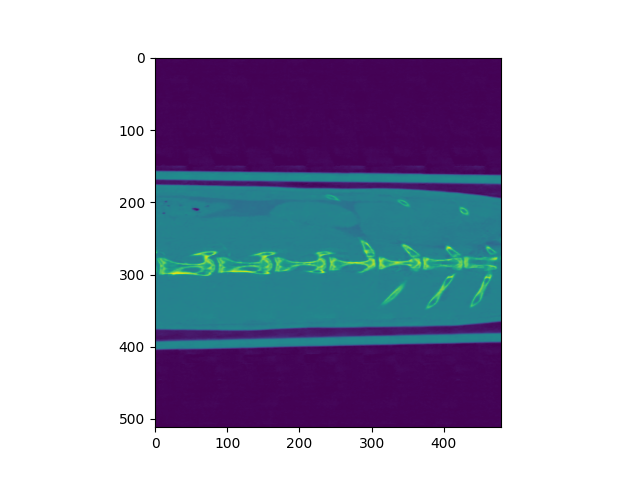

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
#viewS4 = Viewer(s6)
plt.clf()
plt.imshow(d1.acquisition[0].conventional[:,:,455])
print(np.max(d1.acquisition[0].conventional[:,:,455]))
print(np.min(d1.acquisition[0].conventional[:,:,455]))
old_array = d1.acquisition[0].conventional
plt.imshow(old_array[250,:,:])
plt.show()

In [10]:
d1.acquisition[0].conventional = d1.acquisition[0].conventional[:,:,0:239]

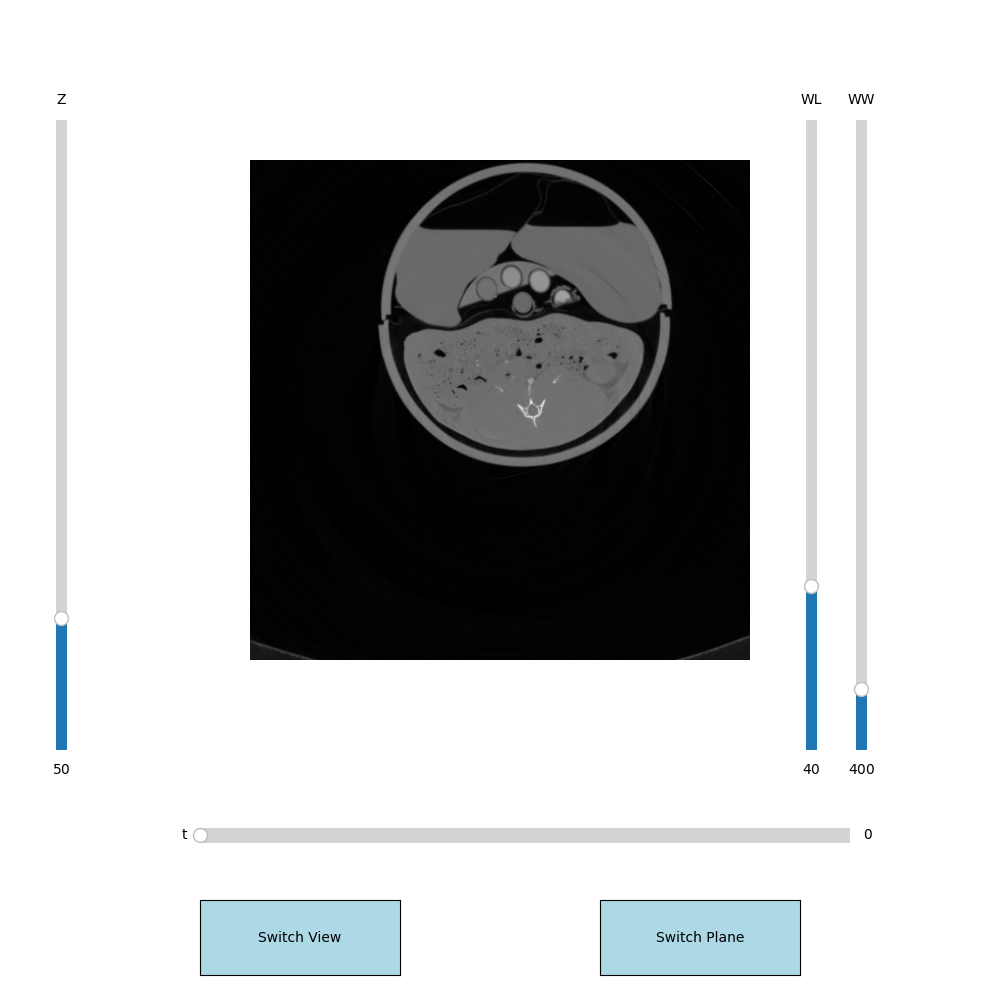

In [11]:
#Viewer(s2)
Viewer(d1)

In [129]:
from SPCCT_4D import vesselDiameter
%matplotlib widget
s5 = Sample("5")
samp = s5
#samp.acquisition[0].conventional[:,:,0:239] = samp.acquisition[0].conventional[:,:,240:479]
#samp.acquisition[0].conventional = samp.acquisition[0].conventional[:,:,0:239]

# Load previously made mask to evaluate quality
#vesselDiameter(samp, "Masks\\IVC_s4_292_t1.npy")
#vesselDiameter(samp, "Vessel_Masks\\SAA_d5_167.npy")
#vesselDiameter(samp, "Kidney_Masks\\r_cortex_d5_41.npy")

vesselDiameter(samp, None)


Available directories:
0: 2021_01_27.4549.300.2024_03_25.AGUIX_Rabbit_26684_a00000
1: 2021_01_27.4549.400.2024_03_25.AGUIX_Rabbit_26684_a00001
2: 2021_01_27.4549.500.2024_03_25.AGUIX_Rabbit_26684_a00002
3: 2021_01_27.4549.600.2024_03_25.AGUIX_Rabbit_26684_a00003
Conventional file 1 total DICOM files found: 480


ValueError: embedded null character

10.770329614269007


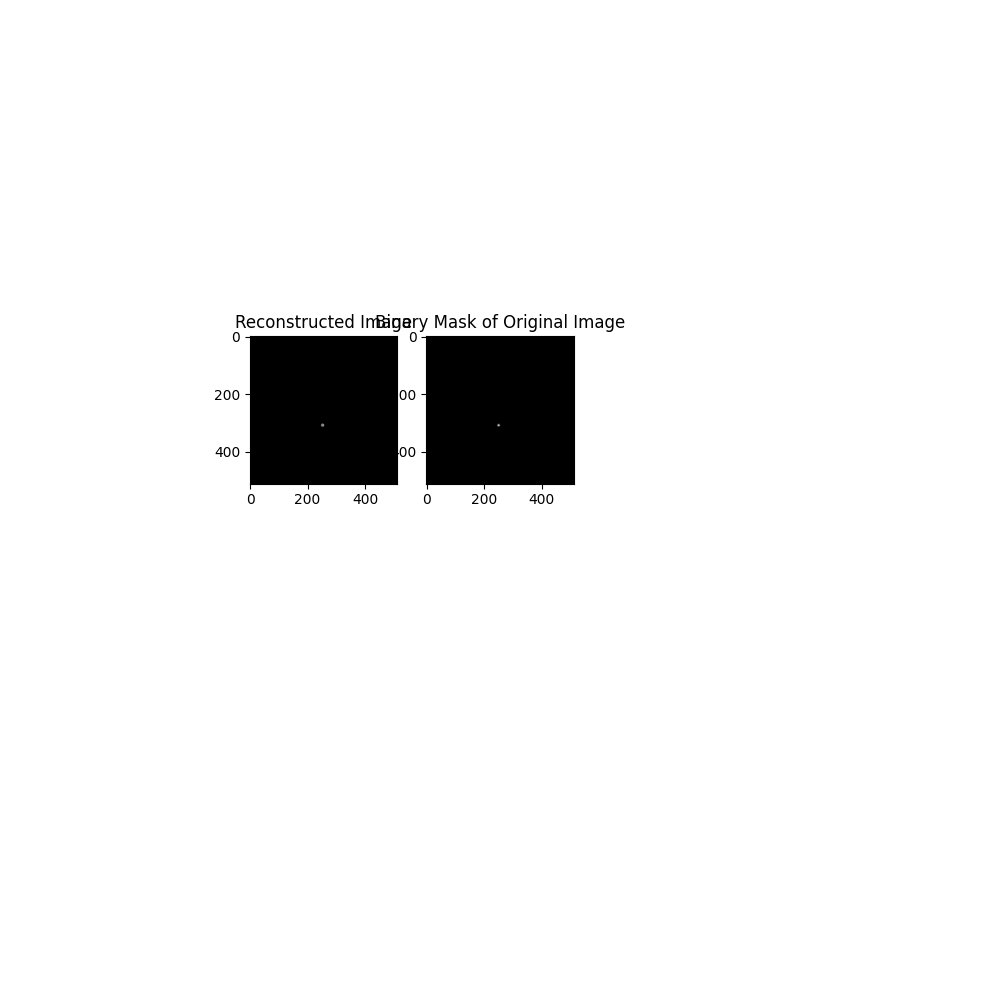

(131, 2)


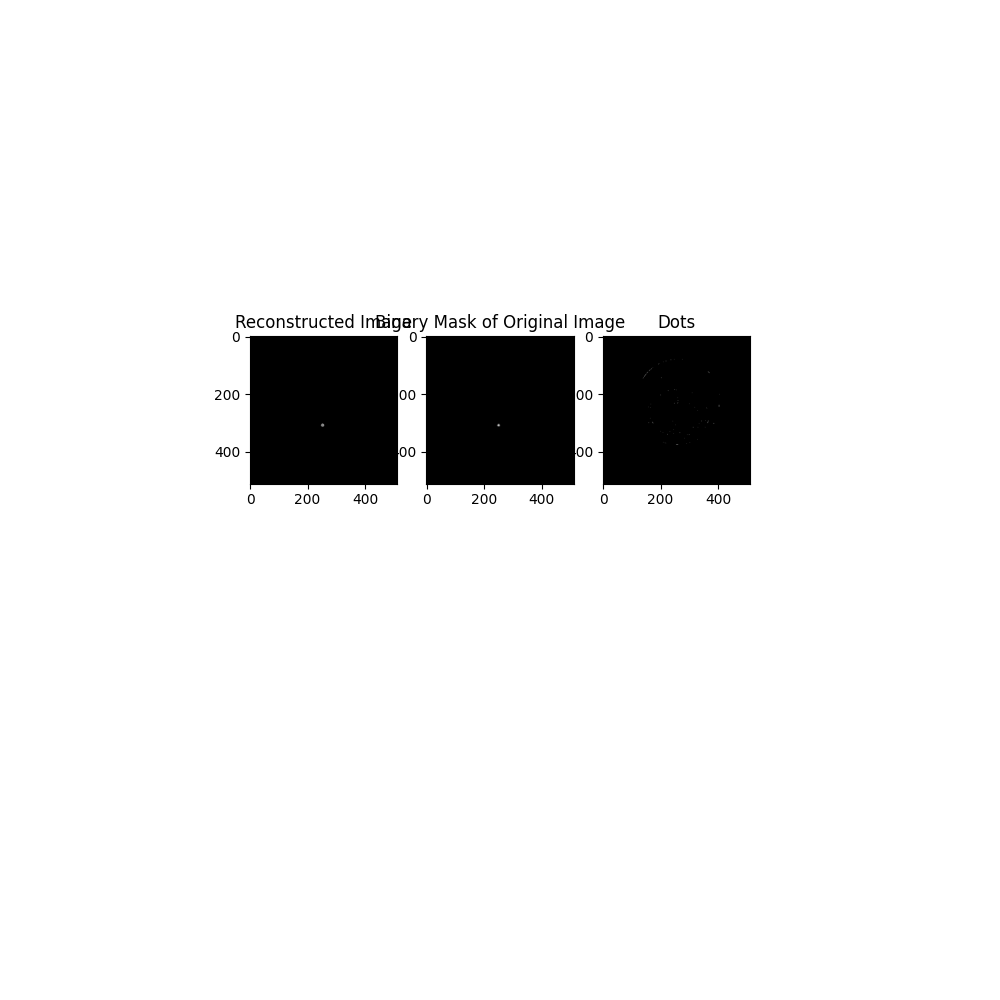

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology as MM
import scipy.ndimage as ndi

start = s1.acquisition[1].conventional[:,:,459]
start_mask = np.load("Masks\\SAA_s1_459.npy")

stop = s1.acquisition[1].conventional[:,:,241]
stop_mask = np.load("Masks\\IRA_s1_241.npy")

#start_mask = np.all(start_mask == [1, 0, 0, 0.5], axis=-1)
#start_mask = start_mask.astype(int)

#stop_mask = np.all(stop_mask == [1, 0, 0, 0.5], axis=-1)
#stop_mask = stop_mask.astype(int)

def greyscale_mask(mask):
    to3D = np.all(mask == [1,0,0,0.5], axis = -1)
    to3D = to3D.astype(int)
    return to3D

def generate_marker_from_coords(shape, coordinates):
    marker = np.zeros(shape)
    marker[coordinates[:, 0], coordinates[:, 1]] = True
    return marker

#edt = ndi.distance_transform_edt(to3D)
    #maxima = MM.h_maxima(edt, 2)
    #coordinates = np.where(maxima == 1)
    #print(coordinates[0])
    #coordinates = np.asarray(coordinates).T
    #print(coordinates[0])
plt.clf()
plt.subplot(1, 3, 1)
plt.imshow(greyscale_mask(start_mask)*start, cmap='gray')
plt.title("Reconstructed Image")

nxt = s1.acquisition[1].conventional[:,:,458]
binary_start = nxt > np.percentile(nxt, 95)
edt = ndi.distance_transform_edt(binary_start)

coords = MM.h_maxima(edt, 2)
coordinates = np.where(coords == 1)
coordinates = np.asarray(coordinates).T

dotplot = generate_marker_from_coords(start.shape, coordinates)

edt = ndi.distance_transform_edt(greyscale_mask(start_mask))
radius = np.max(edt)
print(radius*2)

plt.subplot(1, 3, 2)
plt.imshow(edt, cmap='gray')
plt.title("Binary Mask of Original Image")
plt.show()
print(coordinates.shape)

plt.subplot(1,3,3)
plt.imshow(dotplot, cmap = "gray")
plt.title("Dots")
plt.show()




In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import disk, binary_dilation

class VesselAnalyzer:
    def __init__(self, sample, path=None):
        self.sample = sample
        self.path = path
        self.data = pd.DataFrame(columns=["Signal_HU", "Noise_HU", "CNR_HU", "Signal_Kedge", "Noise_Kedge", "CNR_Kedge"])
        self.masks = []
        self.mask_overlay = None

        self.viewer = Viewer(sample)  # Assuming Viewer is defined elsewhere
        self.cid_click = self.viewer.fig.canvas.mpl_connect('button_press_event', self.on_mouse_click)

    def on_mouse_click(self, event):
        if event.inaxes == self.viewer.ax:
            self.add_circular_roi(event.xdata, event.ydata)
            plt.draw()

    def add_circular_roi(self, x_center, y_center):
        radius = 2.5  # For a diameter of 5 pixels
        washer_radius = 4.5  # For a washer with an outer diameter of 9 pixels (4.5 + 2.5)

        # Create circular ROI and washer mask
        nx, ny = self.viewer.image_display.get_array().shape[1], self.viewer.image_display.get_array().shape[0]
        y, x = np.ogrid[:ny, :nx]
        circular_mask = (x - x_center) ** 2 + (y - y_center) ** 2 <= radius ** 2
        washer_mask = (x - x_center) ** 2 + (y - y_center) ** 2 <= washer_radius ** 2
        washer_mask ^= circular_mask  # Remove the inner circular ROI

        # Process the mask and washer, calculate statistics
        self.process_selection(circular_mask, washer_mask, self.sample)

        # Optionally, create an overlay image to show the ROI
        if self.mask_overlay is not None:
            self.mask_overlay.remove()
        self.mask_overlay = self.viewer.ax.imshow(circular_mask + washer_mask, cmap='coolwarm', alpha=0.5)
        self.viewer.fig.canvas.draw_idle()

    def process_selection(self, circular_mask, washer_mask, sample):
        # Placeholder for image data, replace with actual image data
        measurements = []
        image_data = self.viewer.image_display.get_array()

        # Compute statistics for the circular ROI
        signal_HU = np.mean(image_data[circular_mask])
        noise_HU = np.mean
    
        for i in range(len(sample.acquisition)):
            conventional = sample.acquisition[i].conventional[:, :, self.viewer.slice_slider.val]
        
            # Calculate metrics for conventional and k-edge images
            signal_HU, noise_HU = np.mean(conventional[circular_mask]), np.mean(conventional[washer_mask])
            CNR_HU = (signal_HU - noise_HU) / np.std(conventional[washer_mask])

            kedge = sample.acquisition[i].kedge[:, :, self.viewer.slice_slider.val] if sample.acquisition[i].kedge is not None else None
        
            if kedge is None or (isinstance(kedge, np.ndarray) and np.isnan(kedge).any()):
                signal_Kedge, noise_Kedge, CNR_Kedge = np.nan, np.nan, np.nan
            
            else:
                kedge = sample.acquisition[i].kedge[:, :, self.viewer.slice_slider.val]
                signal_Kedge, noise_Kedge = np.mean(kedge[circular_mask]), np.mean(kedge[washer_mask])
                CNR_Kedge = (signal_Kedge - noise_Kedge) / np.std(kedge[washer_mask])
        
            # Append metrics to the list
            measurements.append([signal_HU, noise_HU, CNR_HU, signal_Kedge, noise_Kedge, CNR_Kedge])
    
        # Convert measurements list to a DataFrame and append it to self.data
        new_data = pd.DataFrame(measurements, columns=self.data.columns)
        self.data = pd.concat([self.data, new_data], ignore_index=True)
        print(self.data)
        self.data.to_csv("dataframe.csv", index = False)


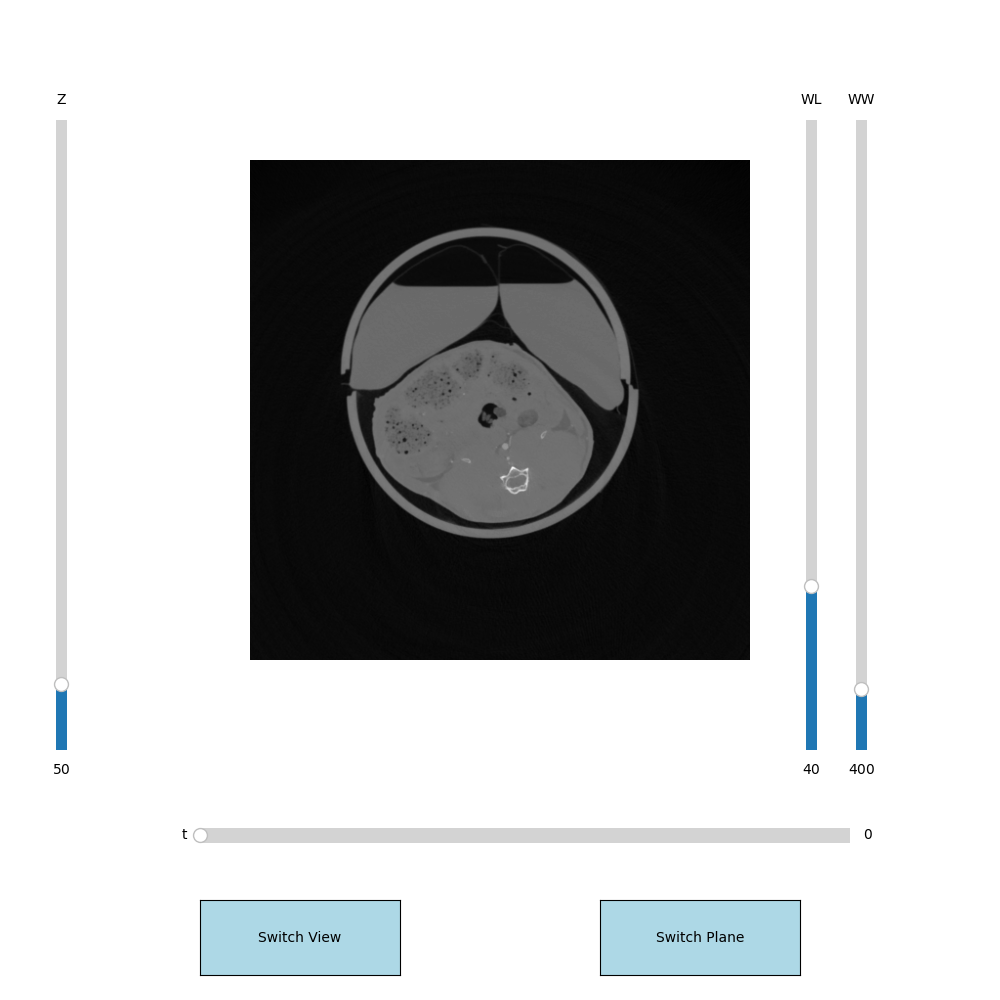

    Signal_HU    Noise_HU    CNR_HU  Signal_Kedge  Noise_Kedge  CNR_Kedge
0 -122.388889 -105.727273 -0.717565      2.605556     2.618636  -0.140698
1   85.222222   84.818182  0.020541      0.044444     0.039091   0.113690
2   89.833333   82.250000  0.424793      0.165556     0.122273   0.536321
3   91.777778   79.068182  0.588491      0.232222     0.150455   0.694004
4   70.888889   66.363636  0.251525      0.000000     0.000000        NaN


C:\Users\Chris\AppData\Local\Temp\ipykernel_3800\3856978850.py:66: RuntimeWarning: invalid value encountered in scalar divide
  CNR_Kedge = (signal_Kedge - noise_Kedge) / np.std(kedge[washer_mask])
C:\Users\Chris\AppData\Local\Temp\ipykernel_3800\3856978850.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data], ignore_index=True)


In [78]:
%matplotlib widget
VesselAnalyzer(s10)